In [85]:
"""
TRANSMORPHER: TRANSFORMER-BASED MORPHOLOGY PARSER
==================================================

This notebook implements a Transformer encoder-decoder model for morphological segmentation
of Quechua words. Unlike segmenter.ipynb which uses BiLSTM for boundary prediction, this
notebook uses a sequence-to-sequence Transformer architecture that directly generates
segmented words with '+' separators.

Key Features:
- Transformer encoder-decoder architecture (sequence-to-sequence)
- Character-level input/output tokenization
- Direct generation of segmented words (e.g., "pikunas" -> "pi+kuna+s")
- Data analysis section: correlation analysis, outlier detection, regression models
- Model checkpointing to avoid redundant training
- Comprehensive evaluation metrics (precision, recall, F1, exact match, split-count accuracy)

Key Differences from segmenter.ipynb:
- Uses Transformer architecture instead of BiLSTM
- Generates segmented strings directly (with '+' separators) instead of predicting boundaries
- Sequence-to-sequence approach rather than sequence labeling
- Includes exploratory data analysis (correlation, regression, outlier detection)

All data is read from the 'data' folder and models are saved to the 'models_transmorpher' folder.
"""

import os
import ast
import json
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib import cm
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pickle

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [87]:
# =========================
# DATA FOLDER CONFIGURATION
# =========================
# All data files should be read from and saved to the data folder
DATA_FOLDER = "data"

# Model folder named after this notebook
MODEL_NAME = "transmorpher"
MODELS_FOLDER = f"models_{MODEL_NAME}"

# Create folders if they don't exist
os.makedirs(DATA_FOLDER, exist_ok=True)
os.makedirs(MODELS_FOLDER, exist_ok=True)

# =========================
# LOAD GOLD STANDARD DATA
# =========================
# The gold standard dataset contains high-quality morphological segmentations
# This is the base training data for the Transformer model
print("Loading gold standard data...")
gold_df = pd.read_parquet(os.path.join(DATA_FOLDER, "Sue_kalt.parquet"))
gold_df['Word'] = gold_df['word']
gold_df['morph'] = gold_df['morph'].str.replace('-', ' ')  # Normalize separators
gold_df['Morph_split_str'] = gold_df['morph']  # String version
gold_df['Morph_split'] = gold_df['morph'].str.split(' ')  # List version
gold_df = gold_df[['Word', 'Morph_split', 'Morph_split_str']]
gold_df.drop_duplicates(subset='Word', keep='first', inplace=True)
gold_df.dropna(subset=['Word'], inplace=True)
print(f"Loaded {len(gold_df):,} gold standard examples")

Loading gold standard data...
Loaded 6,896 gold standard examples


In [88]:
gold_df.head()

,Word,Morph_split,Morph_split_str
0,cementerioman,"[cementerio, man]",cementerio man
1,kawsachkananta,"[kawsa, chka, na, n, ta]",kawsa chka na n ta
2,mañakunpis,"[maña, ku, n, pis]",maña ku n pis
3,imaynapichus,"[imayna, pi, chus]",imayna pi chus
4,qipiyuq,"[qipi, yuq]",qipi yuq


In [89]:
gold_df.shape

(6896, 3)

In [90]:
gold_df['num_morphemes'] = gold_df['Morph_split'].apply(len)
gold_df['word_len'] = gold_df['Word'].apply(len)

In [91]:
gold_df.head()

,Word,Morph_split,Morph_split_str,num_morphemes,word_len
0,cementerioman,"[cementerio, man]",cementerio man,2,13
1,kawsachkananta,"[kawsa, chka, na, n, ta]",kawsa chka na n ta,5,14
2,mañakunpis,"[maña, ku, n, pis]",maña ku n pis,4,10
3,imaynapichus,"[imayna, pi, chus]",imayna pi chus,3,12
4,qipiyuq,"[qipi, yuq]",qipi yuq,2,7


In [92]:
gold_df.tail()

,Word,Morph_split,Morph_split_str,num_morphemes,word_len
8422,kallanku,"[ka, lla, nku]",ka lla nku,3,8
8423,wawachu,"[wawa, chu]",wawa chu,2,7
8424,por ahí,[por_ahí],por_ahí,1,7
8425,ñawpaqinta,"[ñawpaqi, n, ta]",ñawpaqi n ta,3,10
8427,piensarichkan,"[piensa, ri, chka, n]",piensa ri chka n,4,13


In [93]:
heatmap_data = gold_df.groupby(['word_len', 'num_morphemes']).size().unstack(fill_value=0)

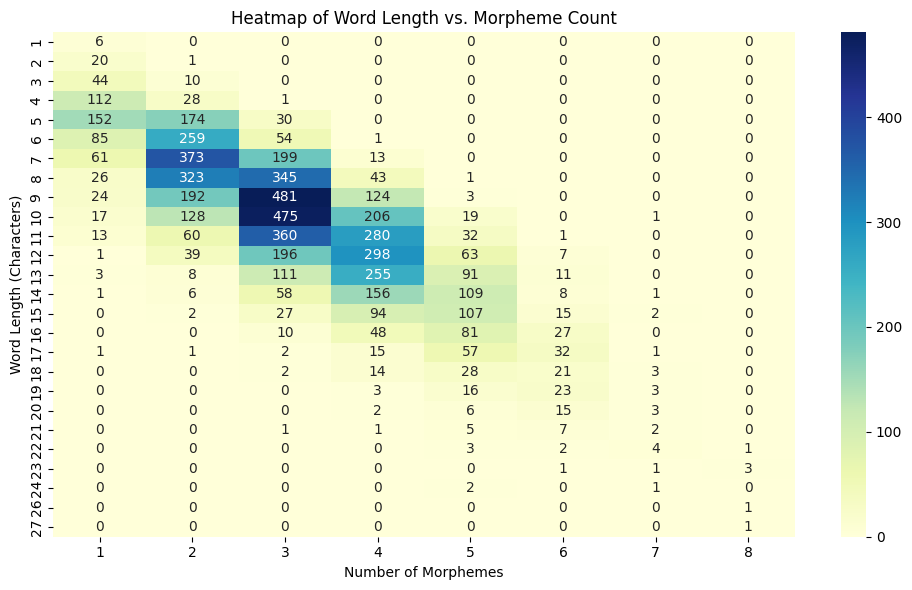

In [94]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Word Length vs. Morpheme Count')
plt.xlabel('Number of Morphemes')
plt.ylabel('Word Length (Characters)')
plt.tight_layout()
plt.show()

In [95]:
# Get the two series
x = gold_df['word_len']
y = gold_df['num_morphemes']

# Pearson (linear)
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman (rank-based)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.3e})")
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.3e})")

Pearson correlation: 0.792 (p=0.000e+00)
Spearman correlation: 0.777 (p=0.000e+00)


Original Size:  (6896, 5)
Cleaned Size:  (4797, 7)


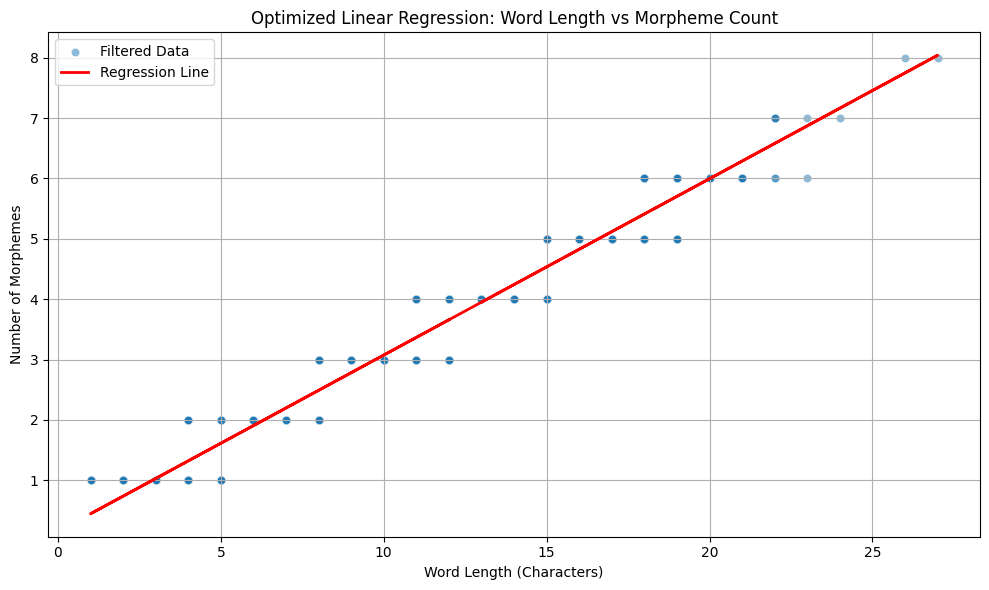

In [96]:
gold_df1 = gold_df.copy()
print("Original Size: ", gold_df1.shape)

X = gold_df1[['word_len']]
y = gold_df1['num_morphemes']

model = LinearRegression()
model.fit(X, y)
gold_df1['predicted'] = model.predict(X)
gold_df1['residual'] = gold_df1['num_morphemes'] - gold_df1['predicted']

std_residual = gold_df1['residual'].std()
filtered_df = gold_df1[np.abs(gold_df1['residual']) <= std_residual]
print("Cleaned Size: ", filtered_df.shape)

X_filtered = filtered_df[['word_len']]
y_filtered = filtered_df['num_morphemes']

model_filtered = LinearRegression()
model_filtered.fit(X_filtered, y_filtered)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='word_len', y='num_morphemes', alpha=0.5, label='Filtered Data')
plt.plot(
    X_filtered, 
    model_filtered.predict(X_filtered), 
    color='red', 
    linewidth=2, 
    label='Regression Line'
)
plt.title('Optimized Linear Regression: Word Length vs Morpheme Count')
plt.xlabel('Word Length (Characters)')
plt.ylabel('Number of Morphemes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
slope = model.coef_[0]
intercept = model.intercept_
print(f"Pre_Refined Regression equation: num_morphemes ≈ {slope:.2f} × word_len + {intercept:.2f}")

slope = model_filtered.coef_[0]
intercept = model_filtered.intercept_
print(f"Refined Regression equation: num_morphemes ≈ {slope:.2f} × word_len + {intercept:.2f}")

Pre_Refined Regression equation: num_morphemes ≈ 0.28 × word_len + 0.32
Refined Regression equation: num_morphemes ≈ 0.29 × word_len + 0.15


In [98]:
r2_full = r2_score(y, gold_df1['predicted'])
print(f"R2 (Original): {r2_full:.3f}")

y_pred_filtered = model_filtered.predict(X_filtered)
r2_filtered = r2_score(y_filtered, y_pred_filtered)
print(f"R2 (Filtered): {r2_filtered:.3f}")

R2 (Original): 0.627
R2 (Filtered): 0.875


Random Forest Evaluation (Before Outlier Removal):
MSE: 0.529
MAE: 0.564
R²:  0.631
Random Forest Evaluation (After Outlier Removal):
MSE: 0.124
MAE: 0.248
R²:  0.890


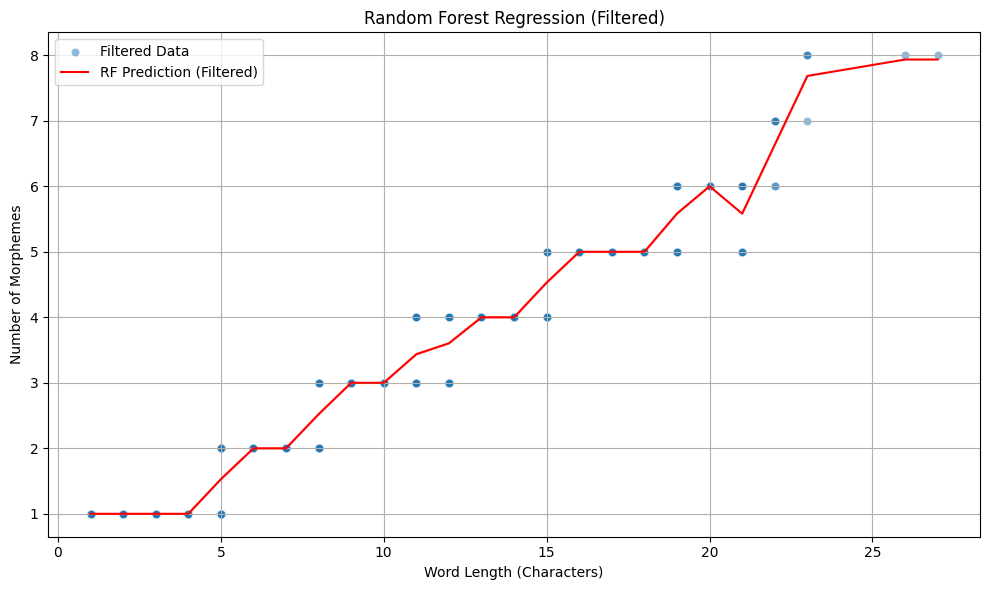

In [99]:
gold_df2 = gold_df.copy()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(gold_df2[['word_len']], gold_df2['num_morphemes'])

gold_df2['predicted_rf'] = rf.predict(gold_df2[['word_len']])
gold_df2['residual_rf'] = gold_df2['num_morphemes'] - gold_df2['predicted_rf']

mse_full = mean_squared_error(gold_df2['num_morphemes'], gold_df2['predicted_rf'])
mae_full = mean_absolute_error(gold_df2['num_morphemes'], gold_df2['predicted_rf'])
r2_full = r2_score(gold_df2['num_morphemes'], gold_df2['predicted_rf'])

std_residual = gold_df2['residual_rf'].std()
filtered_df_rf = gold_df2[np.abs(gold_df2['residual_rf']) <= std_residual].copy()

rf_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
X_filtered = filtered_df_rf[['word_len']]
y_filtered = filtered_df_rf['num_morphemes']
rf_filtered.fit(X_filtered, y_filtered)

filtered_df_rf['predicted_rf'] = rf_filtered.predict(X_filtered)
r2_filtered = r2_score(y_filtered, filtered_df_rf['predicted_rf'])
mse_filtered = mean_squared_error(y_filtered, filtered_df_rf['predicted_rf'])
mae_filtered = mean_absolute_error(y_filtered, filtered_df_rf['predicted_rf'])

print("Random Forest Evaluation (Before Outlier Removal):")
print(f"MSE: {mse_full:.3f}")
print(f"MAE: {mae_full:.3f}")
print(f"R²:  {r2_full:.3f}")

print("Random Forest Evaluation (After Outlier Removal):")
print(f"MSE: {mse_filtered:.3f}")
print(f"MAE: {mae_filtered:.3f}")
print(f"R²:  {r2_filtered:.3f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_df_rf['word_len'], y=filtered_df_rf['num_morphemes'], alpha=0.5, label='Filtered Data')
sns.lineplot(x=filtered_df_rf['word_len'], y=filtered_df_rf['predicted_rf'], color='red', label='RF Prediction (Filtered)')
plt.xlabel('Word Length (Characters)')
plt.ylabel('Number of Morphemes')
plt.title('Random Forest Regression (Filtered)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [100]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(gold_df2[['word_len']])
model_poly = LinearRegression().fit(X_poly, gold_df2['num_morphemes'])
preds_poly = model_poly.predict(X_poly)
r2_before = r2_score(gold_df2['num_morphemes'], preds_poly)
print(f"Polynomial Regression R2 (Before Filtering): {r2_before:.3f}")

residuals_poly = gold_df2['num_morphemes'] - preds_poly
std_resid_poly = residuals_poly.std()
mask = np.abs(residuals_poly) <= std_resid_poly
filtered_df_poly = gold_df2[mask].copy()

X_filtered_poly = poly.fit_transform(filtered_df_poly[['word_len']])
model_poly_filtered = LinearRegression().fit(X_filtered_poly, filtered_df_poly['num_morphemes'])
preds_filtered = model_poly_filtered.predict(X_filtered_poly)
r2_after = r2_score(filtered_df_poly['num_morphemes'], preds_filtered)
print(f"Polynomial Regression R2 (After Filtering):  {r2_after:.3f}")

Polynomial Regression R2 (Before Filtering): 0.628
Polynomial Regression R2 (After Filtering):  0.867


In [101]:
linear_outliers = gold_df1[np.abs(gold_df1['residual']) > std_residual]
rf_outliers = gold_df2[np.abs(gold_df2['residual_rf']) > std_residual]
poly_outliers = gold_df2[np.abs(residuals_poly) > std_resid_poly]

all_outliers = pd.concat([linear_outliers, rf_outliers, poly_outliers])
all_outliers = all_outliers[['word_len', 'num_morphemes']].drop_duplicates()

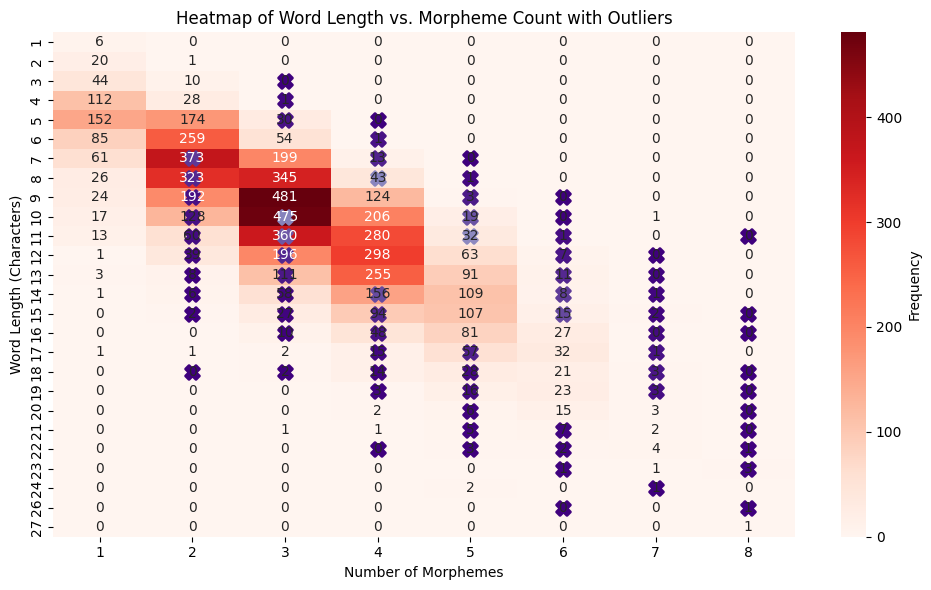

In [102]:
heatmap_data = gold_df.groupby(['word_len', 'num_morphemes']).size().unstack(fill_value=0)

outlier_coords = all_outliers[['word_len', 'num_morphemes']]
outlier_coords = outlier_coords[
    (outlier_coords['word_len'].isin(heatmap_data.index)) & 
    (outlier_coords['num_morphemes'].isin(heatmap_data.columns))
]
outlier_coords = outlier_coords.copy()
outlier_coords['freq'] = outlier_coords.apply(
    lambda row: heatmap_data.at[row['word_len'], row['num_morphemes']], axis=1
)

norm = plt.Normalize(vmin=heatmap_data.values.min(), vmax=heatmap_data.values.max())
colors = cm.Purples_r(norm(outlier_coords['freq'].values))

plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Frequency'})
plt.title('Heatmap of Word Length vs. Morpheme Count with Outliers')
plt.xlabel('Number of Morphemes')
plt.ylabel('Word Length (Characters)')

for j, (_, row) in enumerate(outlier_coords.iterrows()):
    plt.scatter(
        x=row['num_morphemes'] + 0.5,
        y=row['word_len'] + 0.5,
        color=colors[j],
        s=100,
        marker='X',
        linewidths=2,
        label='Outlier' if j == 0 else ""
    )

plt.tight_layout()
plt.show()

In [103]:
# =========================
# PREPARE SEGMENTATION FORMAT
# =========================
# Convert morpheme splits to segmentation format with '+' separators
# This format is used for the Transformer model (sequence-to-sequence)
# Example: "pi kuna s" -> "pi+kuna+s"
gold_df['segmentation'] = gold_df['Morph_split_str'].str.replace(' ', '+')

In [104]:
gold_df.head()

,Word,Morph_split,Morph_split_str,num_morphemes,word_len,segmentation
0,cementerioman,"[cementerio, man]",cementerio man,2,13,cementerio+man
1,kawsachkananta,"[kawsa, chka, na, n, ta]",kawsa chka na n ta,5,14,kawsa+chka+na+n+ta
2,mañakunpis,"[maña, ku, n, pis]",maña ku n pis,4,10,maña+ku+n+pis
3,imaynapichus,"[imayna, pi, chus]",imayna pi chus,3,12,imayna+pi+chus
4,qipiyuq,"[qipi, yuq]",qipi yuq,2,7,qipi+yuq


In [105]:
# =========================
# BUILD VOCABULARIES
# =========================
# Create character-level vocabularies for input (words) and output (segmented words)
# Input vocab: characters in words
# Output vocab: characters in segmented words (includes '+' separator)
special_tokens = ['<pad>', '<s>', '</s>']  # Padding, start, and end tokens
input_chars = sorted({ch for word in gold_df['Word'] for ch in word})
output_chars = sorted({ch for seg in gold_df['segmentation'] for ch in seg})
input_vocab = special_tokens + input_chars
output_vocab = special_tokens + output_chars
input2idx = {ch: idx for idx, ch in enumerate(input_vocab)}
output2idx = {ch: idx for idx, ch in enumerate(output_vocab)}
PAD_IN, START_IN, END_IN = input2idx['<pad>'], input2idx['<s>'], input2idx['</s>']
PAD_OUT, START_OUT, END_OUT = output2idx['<pad>'], output2idx['<s>'], output2idx['</s>']

# =========================
# DATASET CLASS
# =========================
# PyTorch Dataset for Transformer sequence-to-sequence training
# Each sample contains a word and its segmented version
class QuechuaSegDataset(Dataset):
    """
    Dataset for Quechua morphological segmentation.
    
    Args:
        df: DataFrame with 'Word' and 'segmentation' columns
        input2idx: Dictionary mapping input characters to indices
        output2idx: Dictionary mapping output characters to indices
        max_input_len: Maximum input sequence length (auto-computed if None)
        max_output_len: Maximum output sequence length (auto-computed if None)
    """
    def __init__(self, df, input2idx, output2idx, max_input_len=None, max_output_len=None):
        self.words = df['Word'].tolist()
        self.segs = df['segmentation'].tolist()
        self.input2idx = input2idx
        self.output2idx = output2idx
        # Add 2 for <s> and </s> tokens
        self.max_input_len = max_input_len or max(len(w) for w in self.words) + 2
        self.max_output_len = max_output_len or max(len(s) for s in self.segs) + 2

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word = self.words[idx]
        seg = self.segs[idx]
        # Encode source: <s> + chars + </s>, pad to max_input_len
        src = [self.input2idx.get(ch, PAD_IN) for ch in word]
        src = [START_IN] + src + [END_IN]
        src += [PAD_IN] * (self.max_input_len - len(src))
        # Encode target: <s> + segmented chars + </s>, pad to max_output_len
        tgt = [START_OUT] + [self.output2idx[ch] for ch in seg] + [END_OUT]
        tgt += [PAD_OUT] * (self.max_output_len - len(tgt))
        return torch.tensor(src), torch.tensor(tgt)

# =========================
# POSITIONAL ENCODING
# =========================
# Adds positional information to embeddings (required for Transformers)
class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding for Transformer models.
    Adds position-dependent information to token embeddings.
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)  # Even dimensions: sin
        pe[:, 1::2] = torch.cos(pos * div)  # Odd dimensions: cos
        pe = pe.unsqueeze(1)  # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x shape: (seq_len, batch, d_model)
        return x + self.pe[:x.size(0)]

# =========================
# TRANSFORMER MODEL ARCHITECTURE
# =========================
# Encoder-decoder Transformer for sequence-to-sequence morphological segmentation
class MorphSegModel(nn.Module):
    """
    Transformer encoder-decoder model for morphological segmentation.
    
    Architecture:
    1. Encoder: Processes input word character-by-character
    2. Decoder: Generates segmented word character-by-character (with '+' separators)
    3. Output projection: Maps decoder hidden states to output vocabulary
    
    Args:
        in_vocab: Size of input vocabulary (characters in words)
        out_vocab: Size of output vocabulary (characters in segmented words, including '+')
        d_model: Model dimension (embedding size)
        ff: Feed-forward network dimension
        heads: Number of attention heads
        layers: Number of encoder/decoder layers
        drop: Dropout rate
    """
    def __init__(self, in_vocab, out_vocab, d_model=64, ff=128, heads=2, layers=1, drop=0.0):
        super().__init__()
        # Encoder: processes input word
        self.enc_embed = nn.Embedding(in_vocab, d_model, padding_idx=PAD_IN)
        self.pos_enc = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model, heads, ff, drop, batch_first=False)
        self.encoder = nn.TransformerEncoder(enc_layer, layers)

        # Decoder: generates segmented word
        self.dec_embed = nn.Embedding(out_vocab, d_model, padding_idx=PAD_OUT)
        self.pos_dec = PositionalEncoding(d_model)
        dec_layer = nn.TransformerDecoderLayer(d_model, heads, ff, drop, batch_first=False)
        self.decoder = nn.TransformerDecoder(dec_layer, layers)

        # Output projection: maps to output vocabulary
        self.out_proj = nn.Linear(d_model, out_vocab)

    def forward(self, src, tgt, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        """
        Forward pass through the Transformer.
        
        Args:
            src: Input word tokens (seq_len, batch)
            tgt: Target segmented word tokens (seq_len, batch)
            tgt_mask: Causal mask for decoder (prevents looking ahead)
            src_key_padding_mask: Mask for padding in source
            tgt_key_padding_mask: Mask for padding in target
        
        Returns:
            Logits over output vocabulary (seq_len, batch, out_vocab)
        """
        # Encode source word
        e_src = self.pos_enc(self.enc_embed(src))
        memory = self.encoder(e_src, src_key_padding_mask=src_key_padding_mask)
        
        # Decode segmented word
        e_tgt = self.pos_dec(self.dec_embed(tgt))
        out = self.decoder(e_tgt, memory, tgt_mask=tgt_mask,
                           memory_key_padding_mask=src_key_padding_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask)
        
        # Project to output vocabulary
        return self.out_proj(out)


In [106]:
# =========================
# DATASET SPLIT AND DATALOADERS
# =========================
# Split data into 80% training and 20% validation
# Create DataLoaders for batching
dataset = QuechuaSegDataset(gold_df, input2idx, output2idx)
n_train = int(0.8 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, len(dataset) - n_train])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")

Training samples: 5,516
Validation samples: 1,380


In [107]:
# =========================
# MODEL CHECKPOINTING FUNCTIONS
# =========================
# Functions to save and load trained models to avoid retraining

def generate_model_id(d_model, ff, heads, layers, drop, epochs, batch_size, lr, in_vocab_size, out_vocab_size):
    """
    Generate a unique identifier for a model based on its training parameters.
    
    Args:
        All training hyperparameters and vocabulary sizes
    
    Returns:
        A string identifier (hash) for the model
    """
    params_dict = {
        'd_model': d_model,
        'ff': ff,
        'heads': heads,
        'layers': layers,
        'drop': drop,
        'epochs': epochs,
        'batch_size': batch_size,
        'lr': lr,
        'in_vocab_size': in_vocab_size,
        'out_vocab_size': out_vocab_size
    }
    params_str = json.dumps(params_dict, sort_keys=True)
    model_id = hashlib.md5(params_str.encode()).hexdigest()[:16]
    return model_id

def save_model_checkpoint(model, input2idx, output2idx, model_id, models_folder=MODELS_FOLDER):
    """
    Save model checkpoint to the models folder.
    
    Args:
        model: Trained MorphSegModel
        input2idx: Input vocabulary mapping
        output2idx: Output vocabulary mapping
        model_id: Unique identifier for this model
        models_folder: Folder to save models in
    """
    model_dir = os.path.join(models_folder, model_id)
    os.makedirs(model_dir, exist_ok=True)
    
    checkpoint_path = os.path.join(model_dir, "transformer_morph_seg.pt")
    torch.save({
        "model_state": model.state_dict(),
        "input2idx": input2idx,
        "output2idx": output2idx
    }, checkpoint_path)
    
    # Save metadata
    metadata_path = os.path.join(model_dir, "metadata.json")
    with open(metadata_path, "w") as f:
        json.dump({
            'model_id': model_id,
            'in_vocab_size': len(input2idx),
            'out_vocab_size': len(output2idx),
            'model_name': MODEL_NAME
        }, f, indent=2)
    
    print(f"Model checkpoint saved to {model_dir}")
    return model_dir

def load_model_checkpoint(model_id, models_folder=MODELS_FOLDER):
    """
    Load model checkpoint from the models folder.
    
    Args:
        model_id: Unique identifier for the model
        models_folder: Folder where models are saved
    
    Returns:
        Dictionary with 'model_state', 'input2idx', 'output2idx', 'checkpoint_path', 'model_dir' or None if not found
    """
    model_dir = os.path.join(models_folder, model_id)
    checkpoint_path = os.path.join(model_dir, "transformer_morph_seg.pt")
    
    if not os.path.exists(checkpoint_path):
        return None
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    print(f"Model checkpoint loaded from {model_dir}")
    return {
        'model_state': checkpoint['model_state'],
        'input2idx': checkpoint['input2idx'],
        'output2idx': checkpoint['output2idx'],
        'checkpoint_path': checkpoint_path,
        'model_dir': model_dir
    }

# =========================
# MODEL INITIALIZATION
# =========================
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model hyperparameters
D_MODEL = 64
FF = 128
HEADS = 2
LAYERS = 1
DROP = 0.0
EPOCHS = 15
BATCH_SIZE = 16
LR = 1e-4

# Generate model identifier
model_id = generate_model_id(D_MODEL, FF, HEADS, LAYERS, DROP, EPOCHS, BATCH_SIZE, LR, 
                              len(input_vocab), len(output_vocab))

# Try to load existing model
print(f"Checking for existing model with ID: {model_id}")
loaded = load_model_checkpoint(model_id, models_folder=MODELS_FOLDER)

if loaded is not None:
    print(f"Found existing model! Loading from {loaded['model_dir']}")
    input2idx = loaded['input2idx']
    output2idx = loaded['output2idx']
    # Recompute special token indices from loaded vocabularies
    PAD_IN, START_IN, END_IN = input2idx['<pad>'], input2idx['<s>'], input2idx['</s>']
    PAD_OUT, START_OUT, END_OUT = output2idx['<pad>'], output2idx['<s>'], output2idx['</s>']
    model = MorphSegModel(len(input2idx), len(output2idx), d_model=D_MODEL, ff=FF, 
                          heads=HEADS, layers=LAYERS, drop=DROP).to(device)
    model.load_state_dict(loaded['model_state'])
    model.eval()
    print("Model loaded successfully. Skipping training.")
else:
    print(f"No existing model found. Training new model...")
    model = MorphSegModel(len(input_vocab), len(output_vocab), d_model=D_MODEL, ff=FF, 
                          heads=HEADS, layers=LAYERS, drop=DROP).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_OUT)
    optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)

Using device: cuda
Checking for existing model with ID: 96fd8385aa351622
No existing model found. Training new model...


c:\Users\srina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [108]:
# =========================
# TRAINING LOOP
# =========================
# Train the Transformer model for specified number of epochs
# Only runs if no existing model was found

if loaded is None:
    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0
        for src_batch, tgt_batch in train_loader:
            # 1) Move batch to device
            src_batch = src_batch.to(device)           # (batch, src_len)
            tgt_batch = tgt_batch.to(device)           # (batch, tgt_len)

            # 2) Build padding masks (True for padding tokens)
            src_pad_mask = (src_batch == PAD_IN)       # (batch, src_len)
            tgt_pad_mask = (tgt_batch == PAD_OUT)     # (batch, tgt_len)

            # 3) Transpose to (seq_len, batch) as expected by nn.Transformer
            src = src_batch.transpose(0, 1)            # (src_len, batch)
            tgt = tgt_batch.transpose(0, 1)            # (tgt_len, batch)
            tgt_input = tgt[:-1, :]                    # Input to decoder (shifted)
            tgt_output = tgt[1:, :]                    # Target output (shifted)

            # 4) Causal mask for decoder (prevents looking at future tokens)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(
                           tgt_input.size(0)
                       ).to(device)

            # 5) Forward pass: predict next token in segmented sequence
            logits = model(
                src,
                tgt_input,
                tgt_mask=tgt_mask,
                src_key_padding_mask=src_pad_mask,
                tgt_key_padding_mask=tgt_pad_mask[:, :-1]
            )
            
            # 6) Compute loss (cross-entropy over output vocabulary)
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),  # Flatten to (seq*batch, vocab)
                tgt_output.reshape(-1)                # Flatten to (seq*batch,)
            )

            # 7) Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch:02d} — Train Loss: {avg_loss:.4f}")
    
    # Save model after training
    save_model_checkpoint(model, input2idx, output2idx, model_id, models_folder=MODELS_FOLDER)
    print(f"\nTraining complete! Model saved with ID: {model_id}")
else:
    print("Using loaded model. Training skipped.")

c:\Users\srina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 01 — Train Loss: 2.8522
Epoch 02 — Train Loss: 1.9032
Epoch 03 — Train Loss: 1.3817
Epoch 04 — Train Loss: 0.9255
Epoch 05 — Train Loss: 0.6348
Epoch 06 — Train Loss: 0.4772
Epoch 07 — Train Loss: 0.3804
Epoch 08 — Train Loss: 0.3132
Epoch 09 — Train Loss: 0.2653
Epoch 10 — Train Loss: 0.2298
Epoch 11 — Train Loss: 0.2045
Epoch 12 — Train Loss: 0.1829
Epoch 13 — Train Loss: 0.1666
Epoch 14 — Train Loss: 0.1531
Epoch 15 — Train Loss: 0.1409
Model checkpoint saved to models_transmorpher\96fd8385aa351622

Training complete! Model saved with ID: 96fd8385aa351622


In [109]:
# =========================
# INFERENCE FUNCTION
# =========================
# Function to segment a word using the trained Transformer model
def segment_word(word, model, in2idx, out2idx, idx2out, max_len=50, debug=False):
    """
    Segment a word using the trained Transformer model.
    
    Args:
        word: Input word string to segment
        model: Trained MorphSegModel
        in2idx: Input vocabulary mapping
        out2idx: Output vocabulary mapping
        idx2out: Reverse output vocabulary mapping (index to character)
        max_len: Maximum output sequence length
        debug: If True, print debugging information about token generation
    
    Returns:
        Segmented word string (e.g., "pi+kuna+s")
    """
    model.eval()
    # Encode input word: <s> + chars + </s>
    src_idx = [START_IN] + [in2idx.get(ch, PAD_IN) for ch in word] + [END_IN]
    src = torch.tensor(src_idx).unsqueeze(1).to(device)  # (seq_len, 1)
    src_pad = (src.squeeze(1) == PAD_IN).unsqueeze(0)    # (1, seq_len)
    
    # Encode source word
    with torch.no_grad():
        mem = model.pos_enc(model.enc_embed(src))
        mem = model.encoder(mem, src_key_padding_mask=src_pad)
    
    # Decode segmented word autoregressively
    out_ids = [START_OUT]
    if debug:
        print(f"Segmenting '{word}':")
        print(f"  Generated tokens so far: ", end="")
    
    for step in range(max_len):
        tgt = torch.tensor(out_ids).unsqueeze(1).to(device)  # (seq_len, 1)
        mask = nn.Transformer.generate_square_subsequent_mask(len(out_ids)).to(device)
        with torch.no_grad():
            dec_out = model.pos_dec(model.dec_embed(tgt))
            dec = model.decoder(dec_out, mem, tgt_mask=mask, memory_key_padding_mask=src_pad)
            logits = model.out_proj(dec)
        
        # Get probabilities for top predictions
        probs = torch.softmax(logits[-1, 0], dim=0)
        top_probs, top_indices = torch.topk(probs, k=3)
        
        # Predict next token (greedy decoding)
        nxt = logits[-1, 0].argmax().item()
        
        if debug:
            top_chars = [idx2out[idx.item()] for idx in top_indices]
            print(f"\n  Step {step+1}: top predictions = {list(zip(top_chars, top_probs.tolist()))}")
            print(f"    -> Selected: '{idx2out[nxt]}' (prob={probs[nxt].item():.4f})")
        
        # Smart stopping criterion: don't stop too early
        # Calculate current output length (excluding '+' separators)
        current_output = ''.join(idx2out[i] for i in out_ids[1:])
        current_chars = len(current_output.replace('+', ''))
        input_chars = len(word)
        
        # Don't stop if:
        # 1. We haven't generated at least as many characters as the input (accounting for separators)
        # 2. The probability of END_OUT is not very high (below 0.8) AND we're still short
        min_expected_chars = input_chars  # Should generate at least as many chars as input
        
        if nxt == END_OUT:
            # Only stop if we've generated enough characters OR END_OUT probability is very high
            end_prob = probs[END_OUT].item()
            if current_chars >= min_expected_chars or end_prob > 0.8:
                if debug:
                    print(f"  Stopped at END_OUT token (chars: {current_chars}/{min_expected_chars}, prob: {end_prob:.4f})")
                break
            else:
                # Force continue: select the second-best token if it's not END_OUT
                if debug:
                    print(f"  END_OUT predicted but too early (chars: {current_chars}/{min_expected_chars}), forcing continuation...")
                # Find the best non-END_OUT token
                for idx in top_indices:
                    if idx.item() != END_OUT:
                        nxt = idx.item()
                        if debug:
                            print(f"    -> Forced selection: '{idx2out[nxt]}' (prob={probs[nxt].item():.4f})")
                        break
        
        out_ids.append(nxt)
        
        if debug:
            current_seg = ''.join(idx2out[i] for i in out_ids[1:])
            print(f"    Current segmentation: '{current_seg}'")
    
    # Convert indices to characters (skip START_OUT token)
    result = ''.join(idx2out[i] for i in out_ids[1:])
    
    if debug:
        print(f"  Final result: '{result}'")
        print(f"  Expected length check: input '{word}' ({len(word)} chars) -> output '{result}' ({len(result.replace('+', ''))} chars)")
    
    return result

In [110]:
# =========================
# BUILD REVERSE VOCABULARY MAPPING
# =========================
# Create index-to-character mapping for output (needed for inference)
idx2output = {idx: ch for ch, idx in output2idx.items()}

# Example usage with debugging to see what's happening:
print("Example segmentation with debugging:")
test_word = "pikunas"
segmented = segment_word(test_word, model, input2idx, output2idx, idx2output, debug=True)
print(f"\nFinal result: {test_word} -> {segmented}")

# Check what the gold standard segmentation should be
if 'gold_df' in locals():
    gold_seg = gold_df[gold_df['Word'] == test_word]
    if len(gold_seg) > 0:
        print(f"\nGold standard segmentation(s):")
        for idx, row in gold_seg.iterrows():
            print(f"  {row['Morph_split']} -> {row['segmentation']}")

Example segmentation with debugging:
Segmenting 'pikunas':
  Generated tokens so far: 
  Step 1: top predictions = [('p', 0.995413601398468), ('k', 0.0019677935633808374), ('q', 0.0005633870023302734)]
    -> Selected: 'p' (prob=0.9954)
    Current segmentation: 'p'

  Step 2: top predictions = [('i', 0.9990466237068176), ('u', 0.0003304239653516561), ('f', 0.0002755702880676836)]
    -> Selected: 'i' (prob=0.9990)
    Current segmentation: 'pi'

  Step 3: top predictions = [('k', 0.8274876475334167), ('+', 0.1693461835384369), ('n', 0.0007625026628375053)]
    -> Selected: 'k' (prob=0.8275)
    Current segmentation: 'pik'

  Step 4: top predictions = [('u', 0.9993804693222046), ('+', 0.00012311359751038253), ('n', 0.00010743772145360708)]
    -> Selected: 'u' (prob=0.9994)
    Current segmentation: 'piku'

  Step 5: top predictions = [('+', 0.6937442421913147), ('n', 0.3033946752548218), ('u', 0.0004999020602554083)]
    -> Selected: '+' (prob=0.6937)
    Current segmentation: 'piku+'

In [111]:
# =========================
# EVALUATION ON TEST SET
# =========================
# Load test data and evaluate the model with comprehensive metrics
# Similar to segmenter.ipynb evaluation

print("Loading test data...")
test_df = pd.read_parquet(os.path.join(DATA_FOLDER, "cleaned_data_df.parquet"))
print(f"Loaded {len(test_df):,} test examples")

# Build reverse vocabulary mapping
idx2output = {idx: ch for ch, idx in output2idx.items()}

# =========================
# EVALUATION HELPER FUNCTIONS
# =========================
# Functions for evaluating segmentation accuracy

def parse_segmentation(seg_str):
    """
    Parse segmented string (e.g., "pi+kuna+s") into list of morphemes.
    
    Args:
        seg_str: Segmented string with '+' separators
    
    Returns:
        List of morpheme strings
    """
    if not seg_str:
        return []
    return seg_str.split('+')

def is_correct_prediction(predicted, gold_variants):
    """
    Check if predicted segmentation exactly matches any gold variant.
    
    Args:
        predicted: List of predicted morphemes
        gold_variants: List of gold segmentation variants (each is a list of morphemes)
    
    Returns:
        True if prediction matches any gold variant, False otherwise
    """
    # Normalize gold_variants (handle numpy arrays, nested structures)
    if gold_variants is None:
        return False
    
    if isinstance(gold_variants, np.ndarray):
        gold_variants = gold_variants.tolist()
    
    if isinstance(gold_variants, list):
        normalized = []
        for variant in gold_variants:
            if isinstance(variant, np.ndarray):
                normalized.append(variant.tolist())
            elif isinstance(variant, list):
                normalized.append([item.tolist() if isinstance(item, np.ndarray) else item for item in variant])
            else:
                normalized.append(variant)
        gold_variants = normalized
    
    return any(predicted == variant for variant in gold_variants)

def split_count_metrics(predicted_segments, gold_variants):
    """
    Compute split-count accuracy variants:
    - Exact: same number of morphemes as any gold variant
    - +1: one more split than any gold variant
    - -1: one fewer split than any gold variant
    - ±1: difference ≤ 1 with any gold variant
    """
    pred_count = len(predicted_segments)
    
    # Normalize gold_variants
    if gold_variants is None:
        return {"Exact": False, "+1": False, "-1": False, "±1": False}
    
    if isinstance(gold_variants, np.ndarray):
        gold_variants = gold_variants.tolist()
    
    if isinstance(gold_variants, list):
        normalized = []
        for variant in gold_variants:
            if isinstance(variant, np.ndarray):
                normalized.append(variant.tolist())
            elif isinstance(variant, list):
                normalized.append([item.tolist() if isinstance(item, np.ndarray) else item for item in variant])
            else:
                normalized.append(variant)
        gold_variants = normalized
    
    gold_counts = [len(gold) for gold in gold_variants]

    exact = any(pred_count == g for g in gold_counts)
    plus1 = any(pred_count == g + 1 for g in gold_counts)
    minus1 = any(pred_count == g - 1 for g in gold_counts)
    pm1 = any(abs(pred_count - g) <= 1 for g in gold_counts)

    return {"Exact": exact, "+1": plus1, "-1": minus1, "±1": pm1}

# =========================
# EVALUATION LOOP
# =========================
# Predict segmentations for all test words and compute metrics

records = []
all_words = test_df["Word"].tolist()

print("Predicting segmentations for test words...")
for word in all_words:
    # Predict segmentation
    seg_str = segment_word(word, model, input2idx, output2idx, idx2output)
    predicted_segments = parse_segmentation(seg_str)
    
    # Get gold variants
    gold_variants = test_df[test_df["Word"] == word]["Gold"].iloc[0] if len(test_df[test_df["Word"] == word]) > 0 else []
    
    # Exact match accuracy
    correct_exact = is_correct_prediction(predicted_segments, gold_variants)
    
    # Split-count metrics
    split_metrics = split_count_metrics(predicted_segments, gold_variants)
    
    records.append({
        "Word": word,
        "Prediction": predicted_segments,
        "Gold": gold_variants,
        "CorrectExactSeg": correct_exact,
        "CorrectSplitCount": split_metrics["Exact"],
        "SplitCount+1": split_metrics["+1"],
        "SplitCount-1": split_metrics["-1"],
        "SplitCount±1": split_metrics["±1"],
        "OverlapExactAndSplit": correct_exact and split_metrics["Exact"]
    })

results_df = pd.DataFrame(records)

# =========================
# COMPUTE AGGREGATE METRICS
# =========================
# Calculate overall accuracy and split-count metrics

accuracy = results_df["CorrectExactSeg"].mean()
split_exact_acc = results_df["CorrectSplitCount"].mean()
split_plus1_acc = results_df["SplitCount+1"].mean()
split_minus1_acc = results_df["SplitCount-1"].mean()
split_pm1_acc = results_df["SplitCount±1"].mean()
overlap_accuracy = results_df["OverlapExactAndSplit"].mean()

print(f"\n=== Evaluation Results ===")
print(f"Exact segmentation accuracy: {accuracy:.4f}")
print(f"\n=== Split-count metrics ===")
print(f"Split-count (Exact):          {split_exact_acc:.4f}")
print(f"Split-count (+1):             {split_plus1_acc:.4f}")
print(f"Split-count (−1):              {split_minus1_acc:.4f}")
print(f"Split-count (±1):              {split_pm1_acc:.4f}")
print(f"Overlap (Exact ∩ Split):      {overlap_accuracy:.4f}")

# =========================
# SAVE EVALUATION RESULTS
# =========================
# Save evaluation results to the data folder with a descriptive filename
results_output_path = os.path.join(DATA_FOLDER, "transformer_eval_results.csv")
results_df.to_csv(results_output_path, index=False)
print(f"\nEvaluation results saved to {results_output_path}")


Loading test data...
Loaded 913 test examples
Predicting segmentations for test words...

=== Evaluation Results ===
Exact segmentation accuracy: 0.4556

=== Split-count metrics ===
Split-count (Exact):          0.5926
Split-count (+1):             0.2322
Split-count (−1):              0.1205
Split-count (±1):              0.9441
Overlap (Exact ∩ Split):      0.4556

Evaluation results saved to data\transformer_eval_results.csv


In [112]:
# =========================
# EXAMPLE USAGE
# =========================
# Test the model on a few example words
test_words = ["pikunas", "rikuchkani", "ñichkanchus"]
print("Example segmentations:")
for word in test_words:
    segmented = segment_word(word, model, input2idx, output2idx, idx2output)
    print(f"  {word} -> {segmented}")

Example segmentations:
  pikunas -> piku+na+s
  rikuchkani -> riku+chka+ni
  ñichkanchus -> ñi+chka+n+chus
